The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


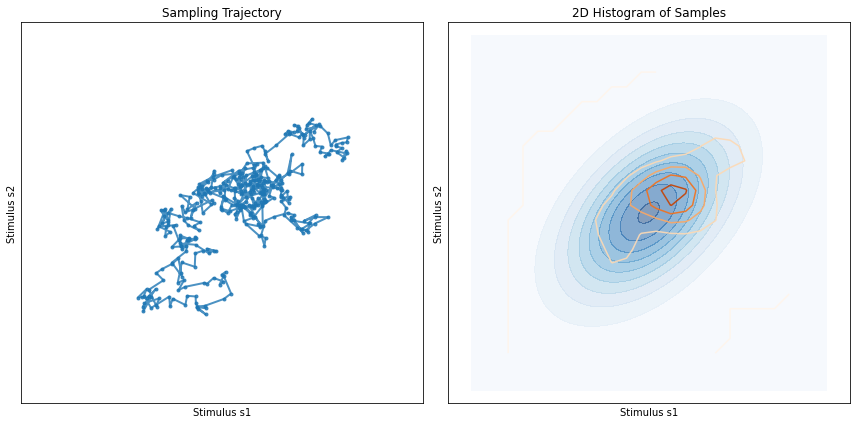

In [ ]:
# Generate a popup window for figures
# %matplotlib tk
# %matplotlib widget
# Autho-reload modules when they change
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal
from MCMC_sampler import hamiltonian_sampling, langevin_sampling, levy_sampling, plot_samples_animation, plot_samples_static

mu = [0, 0]  # Mean of the distribution
Lambda_L = 5 
Lambda_p = 5
Lambda_Mat = Lambda_L * np.eye(2) # Likelihood precision matrix
Lambda_Mat += Lambda_p * np.array([[1, -1], [-1, 1]]) # Add the prior precision matrix

dt = 0.01  # Time step for the simulation

# Langevin sampling dynamics
tau_L = 10
tau_H = 0.6
gamma = 1       # Friction of momentum in Hamiltonian dynamics
mass = 1        # Mass of the particle (determining momentum) in Hamiltonian dynamics
n_steps = 400

# Run sampling dynamics
samples_langevin = langevin_sampling(mu, Lambda_Mat, n_steps=n_steps, dt=dt, tau=tau_L)
samples_hamilton = hamiltonian_sampling(mu, Lambda_Mat, n_steps=n_steps, dt=dt, tau_L=tau_L, tau_H=tau_H, gamma = gamma, mass=mass)
samples_levy = levy_sampling(mu, Lambda_Mat, n_steps=n_steps, dt=dt, tau=100)

# Plot the contour of the target Gaussian as background

# Create grid for contour plot
grid_size = 100
x1 = np.linspace(-1.2, 1.2, grid_size)
x2 = np.linspace(-1.2, 1.2, grid_size)
X1, X2 = np.meshgrid(x1, x2)
pos = np.dstack((X1, X2))

# Multivariate Gaussian PDF
def gaussian_pdf(pos, mu, cov):
    # pos: shape (N, M, 2), mu: shape (2,), cov: shape (2,2)
    rv = multivariate_normal(mean=mu, cov=cov)
    return rv.pdf(pos)
Z = gaussian_pdf(pos, np.array(mu), inv(Lambda_Mat))


fig_langevin = plot_samples_static(samples_langevin, X1, X2, Z)
fig_hamilton = plot_samples_static(samples_hamilton, X1, X2, Z)
fig_levy = plot_samples_static(samples_levy, X1, X2, Z)

# anim_langevin, fig_langevin = plot_samples_animation(samples_langevin, X1, X2, Z)
# anim_hamilton, fig_hamilton = plot_samples_animation(samples_hamilton, X1, X2, Z)
# anim_levy, fig_levy = plot_samples_animation(samples_levy, X1, X2, Z)

plt.tight_layout() 
plt.show(block=False)
# plt.show()

# print("Attempting to save as GIF...")
# anim_langevin.save('animated_curve_langevin.gif', writer='pillow', fps=30)
# anim_hamilton.save('animated_curve_hamilton.gif', writer='pillow', fps=30)
# anim_levy.save('animated_curve_levy.gif', writer='pillow', fps=30)
# print("✓ GIF saved successfully as 'animated_curve.gif'")

In [ ]:
%matplotlib tk
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

x = np.linspace(0, 10, 100)
y = x**2

# Prepare segments
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create gradient alpha values
alphas = np.linspace(0.1, 1.0, len(segments))

# Create LineCollection with varying alpha
lc = LineCollection(segments, colors='tab:blue', alpha=alphas, linewidth=4)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.show()

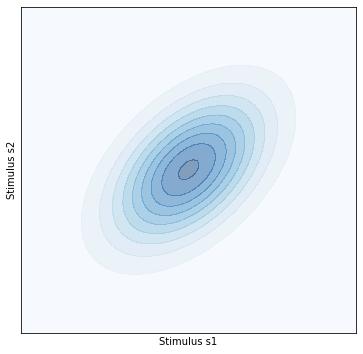

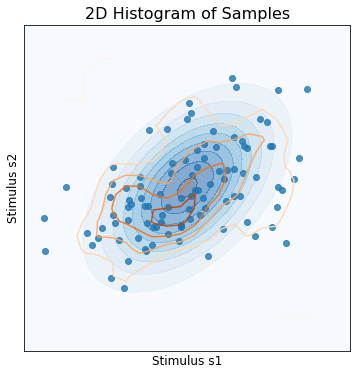

In [1]:
# Illustrate the trial-average of the samples

%load_ext autoreload
%autoreload 2

# %matplotlib tk
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal
from scipy import ndimage
from MCMC_sampler import plot_samples_trials_animation, plot_samples_static

# Distribution parameters
mu = [0, 0]  # Mean of the distribution
Lambda_L = 5 
Lambda_p = 5
Lambda_Mat = Lambda_L * np.eye(2) # Likelihood precision matrix
Lambda_Mat += Lambda_p * np.array([[1, -1], [-1, 1]]) # Add the prior precision matrix
# Lambda = np.asarray(Lambda_Mat)
Lambda = Lambda_Mat
mu = np.asarray(mu)
mu = mu[:,None]

tau = 10
dt = 0.01  # Time step for the simulation
n_steps = 1000
n_trials = 100

d = mu.shape[0]

rng = np.random.default_rng(42)
noise = rng.normal(size=(d, n_trials, n_steps))
x = mu + ((Lambda_L **-1 * np.eye(2)) ** 0.5 )  @ noise[:, :, 0]

# Initial as equilibrium distribution
samples = np.zeros((d, n_trials, n_steps))
samples[:, :, 0] = x

# Precompute for efficiency
sqrt_2dt_tau = np.sqrt(2 * dt / tau)

for t in range(n_steps):
    grad_logp = -Lambda @ (x - mu)
    x = x + dt / tau * grad_logp + sqrt_2dt_tau * noise[:,:,t]
    samples[:,:,t] = x

# Create grid for contour plot
grid_size = 100
x1 = np.linspace(-1.2, 1.2, grid_size)
x2 = np.linspace(-1.2, 1.2, grid_size)
X1, X2 = np.meshgrid(x1, x2)
pos = np.dstack((X1, X2))

# Multivariate Gaussian PDF
def gaussian_pdf(pos, mu, cov):
    # pos: shape (N, M, 2), mu: shape (2,), cov: shape (2,2)
    rv = multivariate_normal(mean=mu, cov=cov)
    return rv.pdf(pos)
Z = gaussian_pdf(pos, mu.flatten(), inv(Lambda_Mat))

# Plot the histogram of the posterior
plt.figure(figsize=(6, 6))
ax_posterior = plt.gca()
ax_posterior.set_xlabel('Stimulus s1')
ax_posterior.set_xticks([])
ax_posterior.set_ylabel('Stimulus s2')
ax_posterior.set_yticks([])
ax_posterior.contourf(X1, X2, Z, levels=10, cmap='Blues', alpha=0.5)
# plt.show(block=False)

# Plot samples over trials

def plot_samples_over_trials(samples, X1, X2, Z):
    fig_combined = plt.figure(figsize=(12, 6))
    ax0 = plt.subplot(1, 2, 1)
    ax1 = plt.subplot(1, 2, 2)

    # Left plot: Langevin trajectory
    # ax0.contourf(X1, X2, Z, levels=10, cmap='Blues', alpha=0.5)
    ax0.set_xlabel('Stimulus s1')
    ax0.set_xticks([])
    ax0.set_ylabel('Stimulus s2')
    ax0.set_yticks([])
    ax0.set_title('Sampling Trajectory') 
    ax0.axis('equal')

    # -------------------------------
    # Right plot: Histogram
    ax1.contourf(X1, X2, Z, levels=10, cmap='Blues', alpha=0.5)
    ax1.set_xlabel('Stimulus s1')
    ax1.set_xticks([])
    ax1.set_ylabel('Stimulus s2')
    ax1.set_yticks([])
    ax1.set_title('2D Histogram of Samples')
    ax1.axis('equal')

    # Sampling trajectory
    ax0.plot(samples[0,:], samples[1,:], 'o', lw=2, alpha=0.8, markersize=3) 

    # Sampling histogram    
    hist, xedges, yedges = np.histogram2d(samples[0,:], samples[1,:], 
                                        bins=20, range=[[-1, 1], [-1, 1]], density=True)
    Xc, Yc = np.meshgrid(
        (xedges[:-1] + xedges[1:]) / 2, 
        (yedges[:-1] + yedges[1:]) / 2)
            
    Zc = ndimage.gaussian_filter(hist.T, sigma=1)
    ax0.contour(Xc, Yc, Zc, levels=4, cmap='Oranges', alpha=0.9) 

    ax0.set_xlim([-1.2, 1.2])
    ax0.set_ylim([-1.2, 1.2])
    
    return fig_combined
# plot_samples_over_trials(samples[:,:,-1], X1,X2, Z)
# plot_samples_over_trials(samples[:,:,-2], X1,X2, Z)

anim_over_trial, fig_over_trial = plot_samples_trials_animation(samples[:,:,-100:], X1, X2, Z)

anim_over_trial.save('animated_over_trials.gif', writer='pillow', fps=30)

# plt.tight_layout() 
# plt.show(block=False)